# **From REST to reasoning: ingest, index, and query with dlt and Cognee.**

## **Instalemos Cognee y Kuzu**

- [Cognee](https://www.cognee.ai/) es una librería de Python de código abierto que conecta puntos de datos y establece verdades fundamentales para mejorar la precisión de tus agentes de IA y modelos de lenguaje.
- [Kuzu](https://kuzudb.com/) es una base de datos de grafos embebida, escalable y extremadamente rápida, también de código abierto.

Leé más sobre Cognee y Kuzu aquí: https://blog.kuzudb.com/post/cognee-kuzu-relational-data-to-knowledge-graph/


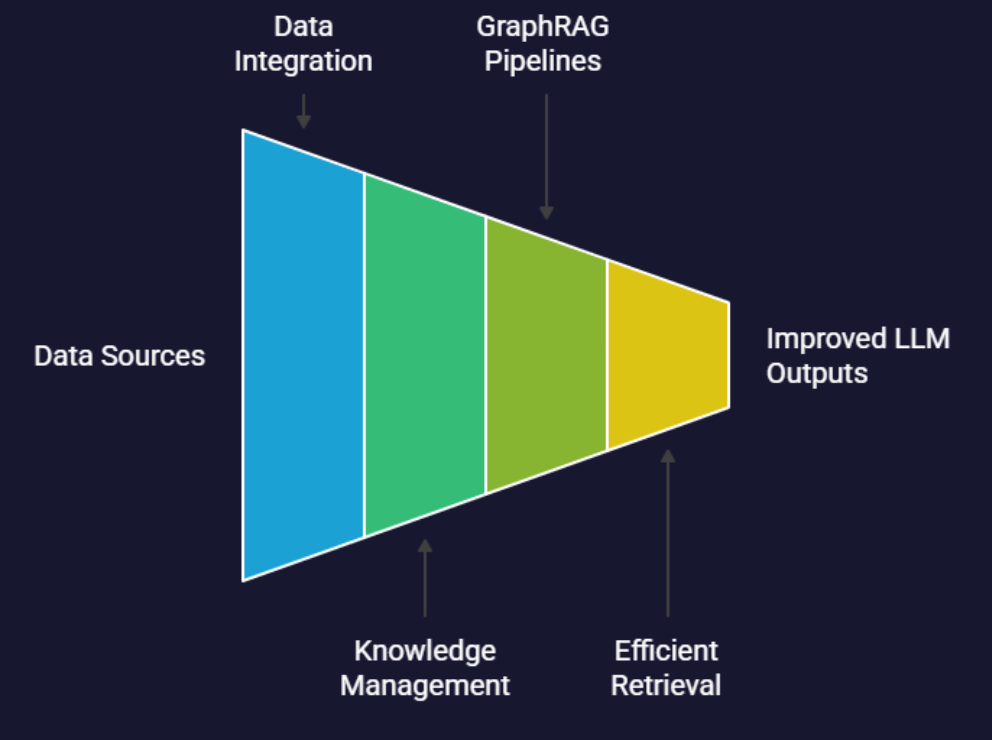

## Configuración del entorno antes de ejecutar Cognee

Antes de ejecutar Cognee, es necesario configurar tu entorno.

Cognee depende de proveedores externos de modelos de lenguaje (LLM), y tenés [una excelente variedad de opciones disponibles](https://docs.cognee.ai/how-to-guides/remote-models) que podés utilizar en tu flujo de trabajo.

### La forma más simple

Si ya contás con una clave de API de OpenAI, simplemente proporciónala. Esto te permitirá utilizar tanto los modelos de lenguaje como los embeddings sin complicaciones.


In [1]:
import os

os.environ["LLM_API_KEY"] = ""
os.environ["GRAPH_DATABASE_PROVIDER"] = "kuzu"

## **Datos que usaremos**

En este ejemplo, solicitaremos datos de una API que provee el **conjunto de datos de taxis de NYC**. Para estos fines, creamos una API que puede entregar los datos con los que ya estás familiarizado.

### **Documentación de la API**:  
- **Datos**: Se entregan en páginas de 1,000 registros.  
- **Paginación**: Cuando no hay más datos, la API devuelve una página vacía.  
- **Detalles**:  
  - **Método**: GET  
  - **URL**: `https://us-central1-dlthub-analytics.cloudfunctions.net/data_engineering_zoomcamp_api`  
  - **Parámetros**:  
    - `page`: Entero (número de página), por defecto es 1.  

Así diseñamos nuestro solicitante:  
1. **Solicitar página por página** hasta recibir una página vacía. Como no sabemos cuánta información hay detrás de la API, debemos asumir que puede ser tan poca como 1,000 registros o tan grande como 10GB.
2. **Usar un generador** para manejar esto de forma eficiente y evitar cargar todos los datos en memoria.


Las fechas de los viajes en taxi corresponden todas al mes de junio de 2009.

## **Particionaremos nuestros datos a nuestra manera**

1. first_10_days
2. second_10_days
3. last_10_days

Lo haremos manualmente para mayor claridad, pero dlt también soporta particionado, como podés ver [aquí](https://dlthub.com/docs/plus/ecosystem/iceberg#partitioning).


In [2]:
import dlt
import requests
import pandas as pd
from datetime import datetime

# Step 1: Create DLT resource
@dlt.resource(write_disposition="replace", name="zoomcamp_data")
def zoomcamp_data():
    url = "https://us-central1-dlthub-analytics.cloudfunctions.net/data_engineering_zoomcamp_api"
    response = requests.get(url)
    data = response.json()

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['Trip_Pickup_DateTime'] = pd.to_datetime(df['Trip_Pickup_DateTime'])

    # Define buckets
    df['tag'] = pd.cut(
        df['Trip_Pickup_DateTime'],
        bins=[
            pd.Timestamp("2009-06-01"),
            pd.Timestamp("2009-06-10"),
            pd.Timestamp("2009-06-20"),
            pd.Timestamp("2009-06-30")
        ],
        labels=["first_10_days", "second_10_days", "last_10_days"],
        right=False
    )

    # Drop rows not in the specified range
    df = df[df['tag'].notnull()]
    yield df


# Step 2: Create and run the pipeline
pipeline = dlt.pipeline(
    pipeline_name="zoomcamp_pipeline",
    destination="duckdb",
    dataset_name="zoomcamp_tagged_data"
)
load_info = pipeline.run(zoomcamp_data())
print(pipeline.last_trace)

2025-07-14 20:33:30,021|[WARNING]|187680|140125579446080|dlt|validate.py|verify_normalized_table:57|In schema `zoomcamp`: The following columns in table 'zoomcamp_data' did not receive any data during this load and therefore could not have their types inferred:
  - rate_code
  - mta_tax

Unless type hints are provided, these columns will not be materialized in the destination.
One way to provide type hints is to use the 'columns' argument in the '@dlt.resource' decorator.  For example:

@dlt.resource(columns={'rate_code': {'data_type': 'text'}})



Run started at 2025-07-14 23:33:26.075703+00:00 and COMPLETED in 6.83 seconds with 4 steps.
Step extract COMPLETED in 2.84 seconds.

Load package 1752536007.1523716 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.09 seconds.
Normalized data for the following tables:
- zoomcamp_data: 998 row(s)

Load package 1752536007.1523716 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 2.86 seconds.
Pipeline zoomcamp_pipeline load step completed in 1.15 seconds
1 load package(s) were loaded to destination duckdb and into dataset zoomcamp_tagged_data
The duckdb destination used duckdb:////home/joviedo/github-repos/llm-zoomcamp-knowledge-base/hw_workshop1/notebook/zoomcamp_pipeline.duckdb location to store data
Load package 1752536007.1523716 is LOADED and contains no failed jobs

Step run COMPLETED in 6.82 seconds.
Pipeline zoomcamp_pipeline load step completed in 1.15 seconds
1 load

In [3]:
dataset = pipeline.dataset().zoomcamp_data.df()

dataset

,end_lat,end_lon,fare_amt,passenger_count,payment_type,start_lat,start_lon,tip_amt,tolls_amt,total_amt,trip_distance,trip_dropoff_date_time,trip_pickup_date_time,store_and_forward,surcharge,vendor_name,tag
0,40.742963,-73.980072,45.0,1,Credit,40.641525,-73.787442,9.0,4.15,58.15,17.52,2009-06-14 23:48:00,2009-06-14 23:23:00,NaN,0.0,VTS,second_10_days
1,40.740187,-74.005698,6.5,1,Credit,40.722065,-74.009767,1.0,0.00,8.50,1.56,2009-06-18 17:43:00,2009-06-18 17:35:00,NaN,1.0,VTS,second_10_days
2,40.718043,-74.004745,12.5,5,Credit,40.761945,-73.983038,2.0,0.00,15.50,3.37,2009-06-10 18:27:00,2009-06-10 18:08:00,NaN,1.0,VTS,second_10_days
3,40.739637,-73.985233,4.9,1,CASH,40.749802,-73.992247,0.0,0.00,5.40,1.11,2009-06-14 23:58:00,2009-06-14 23:54:00,NaN,0.5,VTS,second_10_days
4,40.730032,-73.852693,25.7,1,CASH,40.776825,-73.949233,0.0,4.15,29.85,11.09,2009-06-13 13:23:00,2009-06-13 13:01:00,NaN,0.0,VTS,second_10_days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,40.742998,-73.919065,6.9,1,CASH,40.743523,-73.918735,0.0,0.00,6.90,1.83,2009-06-10 06:23:00,2009-06-10 06:16:00,NaN,0.0,VTS,second_10_days
994,40.731953,-73.985330,7.3,1,CASH,40.733143,-74.006408,0.0,0.00,7.80,1.59,2009-06-10 05:11:00,2009-06-10 05:02:00,NaN,0.5,VTS,second_10_days
995,40.712640,-73.998870,5.7,1,CASH,40.711865,-74.010158,0.0,0.00,5.70,0.79,2009-06-13 12:45:00,2009-06-13 12:37:00,NaN,0.0,VTS,second_10_days
996,40.732998,-74.007113,7.3,2,CASH,40.744658,-73.992063,0.0,0.00,7.80,1.87,2009-06-09 21:34:00,2009-06-09 21:25:00,NaN,0.5,VTS,first_10_days


In [4]:
dataset["tag"].value_counts()

tag
first_10_days     481
second_10_days    295
last_10_days      222
Name: count, dtype: int64

## **¡Vamos a cargar datos en Cognee!**

Aquí, estoy usando `cognee.add()` y luego `cognee.cognify()` directamente.

Si querés aprender cómo usar conjuntos de datos relacionales en Cognee, por favor visitá la [documentación](https://docs.cognee.ai/tutorials/load-your-relational-database) :)


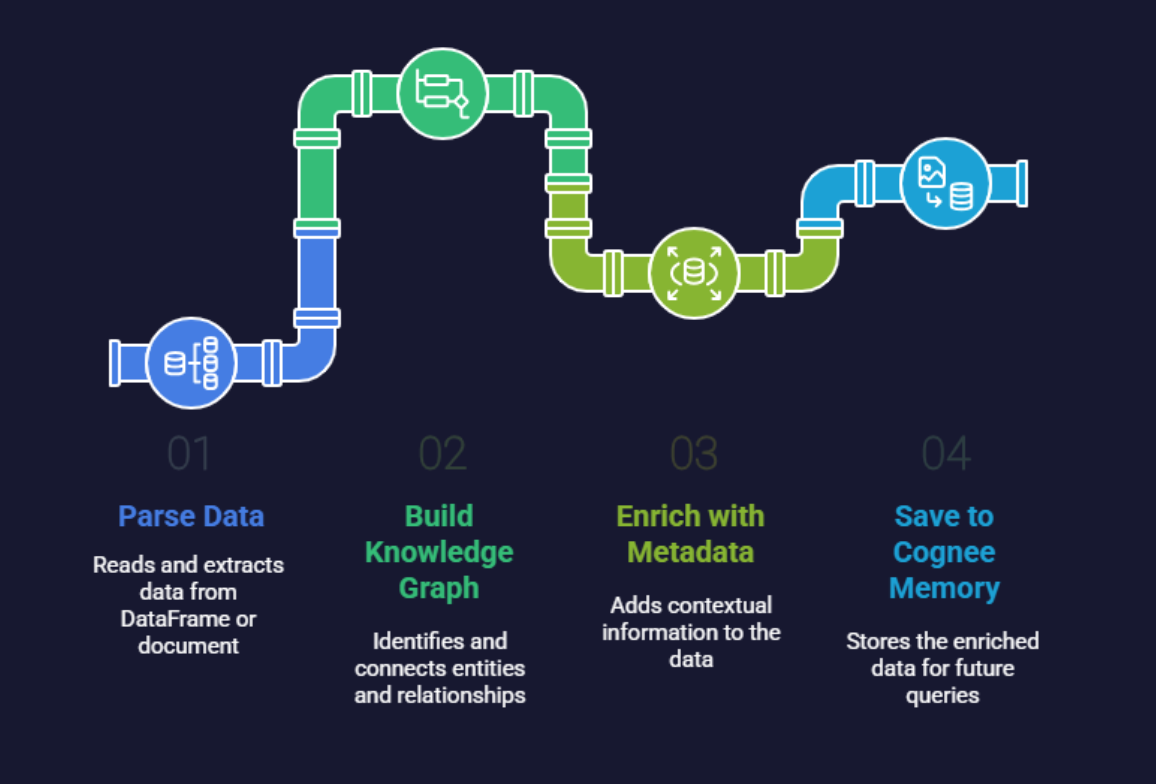

In [5]:
import cognee
from cognee.shared.logging_utils import get_logger, ERROR
from cognee.api.v1.visualize.visualize import visualize_graph
from cognee.api.v1.search import SearchType
from cognee.modules.engine.models import NodeSet
import os

async def main():
    await cognee.prune.prune_data()
    await cognee.prune.prune_system(metadata=True)

    # Add the first 10 days
    df_set1 = dataset.loc[dataset["tag"] == "first_10_days"]
    df_set1.drop(columns=["tag"], inplace=True)
    df_set1 = df_set1.to_json(orient="records", lines=False)
    await cognee.add(df_set1, node_set=["first_10_days"])

    # Add the second 10 days
    df_set2 = dataset.loc[dataset["tag"] == "second_10_days"]
    df_set2.drop(columns=["tag"], inplace=True)
    df_set2 = df_set2.to_json(orient="records", lines=False)
    await cognee.add(df_set2, node_set=["second_10_days"])

    # Add the last 10 days
    df_set3 = dataset.loc[dataset["tag"] == "last_10_days"]
    df_set3.drop(columns=["tag"], inplace=True)
    df_set3 = df_set3.to_json(orient="records", lines=False)
    await cognee.add(df_set3, node_set=["last_10_days"])

    await cognee.cognify()

    visualization_path = "/home/joviedo/graph_visualization.html"
    await visualize_graph(visualization_path)


2025-07-14T23:34:30.967242 [info     ] Logging initialized            [cognee.shared.logging_utils] cognee_version=0.2.0 os_info='Linux 5.15.153.1-microsoft-standard-WSL2 (#1 SMP Fri Mar 29 23:14:13 UTC 2024)' python_version=3.13.3 structlog_version=25.4.0

2025-07-14T23:34:30.968477 [info     ] Want to learn more? Visit the Cognee documentation: https://docs.cognee.ai [cognee.shared.logging_utils]

HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


Ejecutá la función `main()`. Puede que tome un tiempo, así que aprovechá para prepararte una taza de café.

In [6]:
await main()


2025-07-14T23:35:49.914474 [info     ] Cleared all data from graph while preserving structure [cognee.shared.logging_utils]
2025-07-14T23:35:52.281119 [info     ] Deleted Kuzu database files at /home/joviedo/github-repos/llm-zoomcamp-knowledge-base/workshop1/.venv/lib/python3.13/site-packages/cognee/.cognee_system/databases/cognee_graph_kuzu [cognee.shared.logging_utils]
2025-07-14T23:35:53.127679 [info     ] Database deleted successfully. [cognee.shared.logging_utils]/tmp/ipykernel_187680/2867422918.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_set1.drop(columns=["tag"], inplace=True)

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client20:

User 71110438-b9ed-42b5-b3e8-8bac8cf64210 has registered.



2025-07-14T23:36:09.155407 [info     ] Pipeline run started: `34cd567d-a525-5706-8d9d-426175844e53` [run_tasks(tasks: [Task], data)]
2025-07-14T23:36:09.484424 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]
2025-07-14T23:36:09.796068 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]
2025-07-14T23:36:15.975174 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]
2025-07-14T23:36:16.258926 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]
2025-07-14T23:36:16.564842 [info     ] Pipeline run completed: `34cd567d-a525-5706-8d9d-426175844e53` [run_tasks(tasks: [Task], data)]/tmp/ipykernel_187680/2867422918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_set2.drop(columns=["tag"], inplace=True)

2025-07-

### **Mirá el grafo de conocimiento**

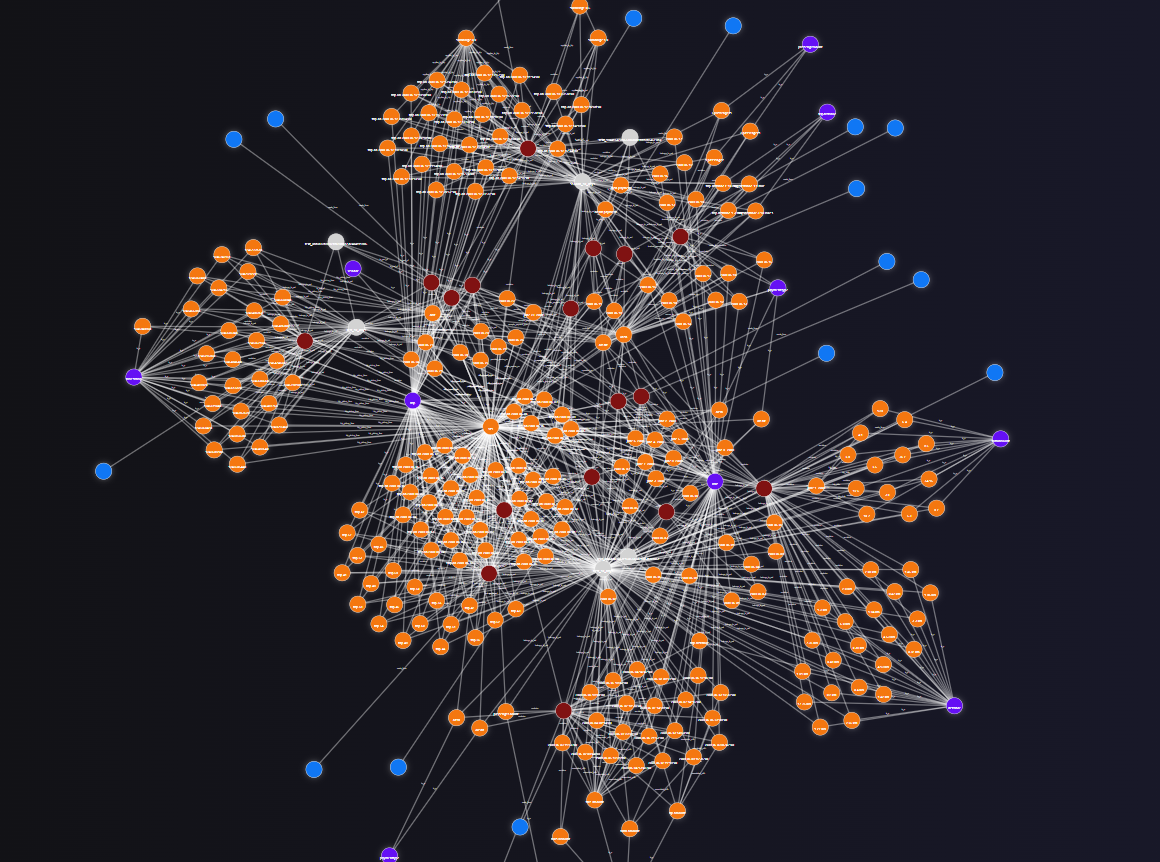

## **Busqueda**

In [7]:
async def search_cognee(query, node_set, query_type=SearchType.GRAPH_COMPLETION):
    answer = await cognee.search(
        query_text=query,
        query_type=query_type,
        node_type=NodeSet,
        node_name=node_set,
        top_k=5 # limit search for retrieval
    )
    return answer

In [8]:
results = await search_cognee(
    "What's in this knowledge graph?",
    node_set=["first_10_days"]
)

20:41:02 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large20:41:02 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large20:41:02 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large20:41:02 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large20:41:02 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/text-embedding-3-large
selected model name for cost calculation: openai/text-embedding-3-large20:41:02 - LiteLLM:INFO: cost_calcu

In [9]:
print(results[0])

The knowledge graph contains information about taxi trips that occurred on specific dates (2009-06-03, 2009-06-04, and 2009-06-08), detailing the pickup and dropoff locations, fares, passenger counts, payment types, and other trip-related data. Each trip node is connected to a detailed dataset that includes attributes such as fare amount, trip distance, and vendor information.
